# An introduction to overfitting

In the previous lab we have designed an MLP network for image classification, and we have trained it in a rather straightforward fashion, which in practice is a bit risky. Indeed, our model was designed and trained for minimizing the loss on the training set for a given number of epochs. As such, we might end up with a model that is very good at predicting the data from this training set, but is unable to *generalize* to unseen/new data (e.g., from the test set). This behavior is called **overfitting** and is a major problem in deep learning, wich we adress in this script.

<center><a href="https://medium.com/geekculture/investigating-underfitting-and-overfitting-70382835e45c">
    <img src="https://miro.medium.com/max/1400/1*OeJVQ7sEvOJGxfGSCpbzyA.png" width="600"></a></center>
    
More specifically, we study two common sources of overfitting:

- Training for too many epochs.
- Using an over-parametrized (i.e., too large) model (this corresponds to the figure above).

In [1]:
import torch
import torch.nn as nn
import torchvision
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, random_split
import copy

## Dataset and model

As in the previous lab, we work with the MNIST dataset and we use a simple 3-layer MLP. We provide the code below.

In [2]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Load the MNIST training dataset (in this script we don't need the test set), and take a small subset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
num_classes = len(train_data.classes)
train_data = Subset(train_data, torch.arange(500))

In [3]:
# MLP classifier
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())
        self.hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        out = self.output_layer(y)
        return out

In [4]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

In [5]:
# Instanciate the network and initialize the parameters for reproducibility
input_size = train_data[0][0][0].shape[0]*train_data[0][0][0].shape[1]
hidden_size = 10
output_size = num_classes
model = MLPClassif(input_size, hidden_size, output_size)
model.apply(init_params)

MLPClassif(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
  )
  (hidden_layer): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=10, out_features=10, bias=True)
)

## The validation set

Until now, we have splitted our data into two sets: training and testing. A key ingredient in avoiding overfitting is the usage of an additional *validation* (or *development*) set. The data is then split into:

- the *training set*, used to train the model's parameters.
- the *validation set*, used to evaluate the capacity of the model to generalize to unseen data.
- the *test set*, used to compare different baselines / methods after training.

<center><a href="https://www.v7labs.com/blog/train-validation-test-set">
    <img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/61568656a13218cdde7f6166_training-data-validation-test.png" width="400"></a></center>

In [6]:
# Define the validation set by splitting the training data into 2 subsets (80% training and 20% validation)
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.manual_seed(0))
print(len(train_data), len(valid_data))

# Create the corresponding dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(0))
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

400 100


## Training with validation

A first simple approach to avoid overfitting is to monitor the performance of the model on the validation set over epochs when training. At each epoch we compute the loss on the validation set, and check how it behaves: if the validation loss decreases, then we can continue training. Conversely, if the validation loss increases, it means the model has overfitted, so we need to stop training. Here, we run training with a specified maximum number of epochs, and we save the model yielding the lowest validation loss as the optimal/best one.

<center><a href="https://theaisummer.com/regularization/">
    <img src="https://theaisummer.com/static/7a6353ed78b045f32e4ac39b0b4d66d2/a878e/early-stopping.png" width="400"></a></center>
    

**Note**: In practice, instead of computing the validation *loss/error* (which ideally should decrease), we can compute the validation *accuracy* (which ideally should increase). The concept is the same, but it is usually better to use a validation metric that is as close as possible or equal to the test metric (here: accuracy).

In [7]:
# Evaluation function
def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

The training function is very similar to what we did in the previous lab, so feel free to reuse it. There are a few main differences:

- The function now takes an extra input argument: the validation dataloader.
- Instead of SGD, we we use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer, which is a more efficient algorithm (the pytorch code is similar: you need to provide the model's parameters and the learning rate).
- At the end of each epoch, compute the accuracy on the validation set (use the provided eval function): if the accuracy is increasing, then store the current model as the optimal one.
- The function should return the *optimal model* (that is, the model corresponding to the best validation accuracy), the list of training losses over epochs, and the list of validation accuracy over epochs.

<span style="color:red">**Exercice 1**</span> Write the training function with validation. Using the training parameters below, train the model, and plot the training loss and validation accuracy (on two different subplots). What do you remark? Is it beneficial to monitor the validation accuracy?

In [8]:
# Training parameters
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50
learning_rate = 0.001

**Note**: We conducted training for all epochs, and we simply recorded the best performing model. Proper early stopping would mean that we interrupt training when no improvement is observed after the best validation loss has been obtained (this number of epochs is called a *patience* parameter, since it corresponds to the "waiting time" after the best validation score is obtained).
This allows to reduce the computational time in addition to yielding the best model.


## Adjusting the model's capacity

The number of parameters in the network (i.e., the model's *capacity*) is expected to have a major impact on performance. Too few parameters might yield bad performance (underfitting), while too many might hamper the ability of the network to generalize (overfitting).


<center><a href="https://classic.d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html">
    <img src="https://classic.d2l.ai/_images/capacity-vs-error.svg" width="400"></a></center>
    

Here, we study it by varying the number of hidden layers and checking how the validation accuracy behaves.

Below we consider a general classifier module, where the number of hidden layers is passed as an input parameter. To create and stack together several layers, we can use the [ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) object, along with a simple loop.

In [9]:
# On this example, we stack 5 {Linear + Relu} layers
list_layer = nn.ModuleList([nn.Sequential(nn.Linear(10, 10), nn.ReLU()) for l in range(5)])
print(list_layer)

ModuleList(
  (0-4): 5 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
)


In [12]:
import torch
import torch.nn as nn

class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super().__init__()
        
        # input layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()  # activation
        )
        
        # hidden layers
        self.hidden_layers = nn.ModuleList()  # list of hidden layers
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(
                nn.Sequential(
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU()  # # activation
                )
            )
        
        # output layer
        self.output_layer = nn.Linear(hidden_size, output_size)  #  maps from hidden_size to output_size.
    
    def forward(self, x):
        # flatten the input if it's an image
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        
        # to input layer
        x = self.input_layer(x)
        
        # iterates over hidden layesr
        for layer in self.hidden_layers:
            x = layer(x)
        
        # to output layer
        out = self.output_layer(x)
        return out

In [13]:
# TO DO: Set hidden_size=16 (better performance) and instanciate an MLP classifier with 2 layers. Print the number of parameters

input_size = 28 * 28   # MNIST images 28x28 pixels
hidden_size = 16       
output_size = 10       # number of classes in MNIST (digits 0-9)
num_hidden_layers = 2  

# instantiate the model
model = MLPClassif(input_size, hidden_size, output_size, num_hidden_layers)

# calculate and print the number of parameters
def print_num_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total number of parameters: {total_params}')
    return total_params

In [14]:
# initialize the model params
model.apply(init_params)

# print the num of params
total_params = print_num_params(model)

Total number of parameters: 13274


<span style="color:red">**Exercice 2**</span> For a number of hidden layers equal to 1, 3, and 5:
- Instanciate a model (remember to **initialize** the parameters to ensure reproducibility)
- Train the model and record the validation accuracy
- Display the maximum validation accuracy over epochs (either print the value, or plot the max accuracy vs. number of hidden layers)

What do you observe? What's the best model / number of hidden layers to use?

In [15]:
import copy

def train_with_validation(model, train_dataloader, valid_dataloader, loss_fn, optimizer, num_epochs):
    best_model = None
    best_val_accuracy = 0.0
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # training mode
        running_loss = 0.0
        
        for images, labels in train_dataloader:
            # flatten images
            images = images.view(images.size(0), -1)
            
            # forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # avg loss over the epoch
        epoch_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_loss)
        
        # evaluate on validation set
        val_accuracy = eval_mlp_classifier(model, valid_dataloader)
        val_accuracies.append(val_accuracy)
        
        # track the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    return best_model, train_losses, val_accuracies

In [16]:
# list to store the maximum validation accuracies for each model
max_val_accuracies = []
hidden_layers_list = [1, 3, 5]

for num_hidden_layers in hidden_layers_list:
    print(f'\nTraining model with {num_hidden_layers} hidden layer(s)')
    
    # instantiate the model
    model = MLPClassif(input_size, hidden_size, output_size, num_hidden_layers)
    
    # initialize params for reproducibility
    torch.manual_seed(0)
    model.apply(init_params)
    
    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # train
    best_model, train_losses, val_accuracies = train_with_validation(
        model, train_dataloader, valid_dataloader, loss_fn, optimizer, num_epochs
    )
    
    # store the max validation accuracy
    max_val_accuracy = max(val_accuracies)
    max_val_accuracies.append(max_val_accuracy)
    
    print(f'Max Validation Accuracy for {num_hidden_layers} hidden layer(s): {max_val_accuracy:.2f}%')


Training model with 1 hidden layer(s)
Epoch [1/50], Loss: 2.1201, Validation Accuracy: 16.00%
Epoch [2/50], Loss: 1.5080, Validation Accuracy: 49.00%
Epoch [3/50], Loss: 0.9965, Validation Accuracy: 57.00%
Epoch [4/50], Loss: 0.6725, Validation Accuracy: 72.00%
Epoch [5/50], Loss: 0.4700, Validation Accuracy: 76.00%
Epoch [6/50], Loss: 0.3220, Validation Accuracy: 74.00%
Epoch [7/50], Loss: 0.2550, Validation Accuracy: 78.00%
Epoch [8/50], Loss: 0.1845, Validation Accuracy: 79.00%
Epoch [9/50], Loss: 0.1415, Validation Accuracy: 79.00%
Epoch [10/50], Loss: 0.1104, Validation Accuracy: 78.00%
Epoch [11/50], Loss: 0.0889, Validation Accuracy: 77.00%
Epoch [12/50], Loss: 0.0720, Validation Accuracy: 78.00%
Epoch [13/50], Loss: 0.0564, Validation Accuracy: 79.00%
Epoch [14/50], Loss: 0.0444, Validation Accuracy: 78.00%
Epoch [15/50], Loss: 0.0382, Validation Accuracy: 77.00%
Epoch [16/50], Loss: 0.0317, Validation Accuracy: 78.00%
Epoch [17/50], Loss: 0.0245, Validation Accuracy: 78.00%
E

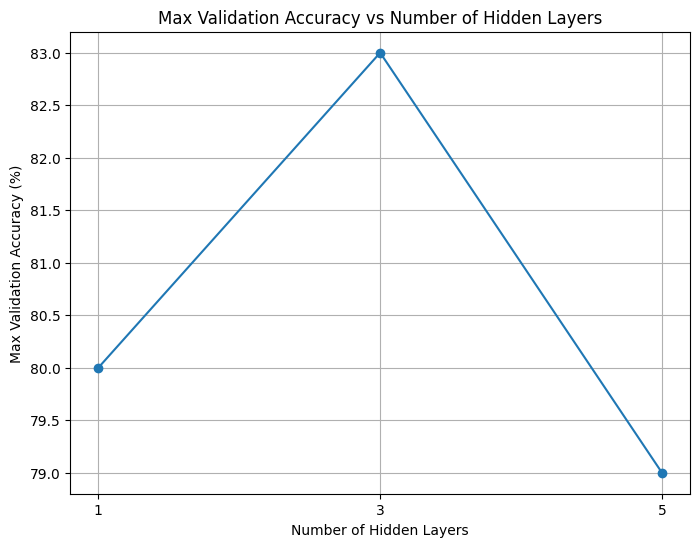

In [17]:
import matplotlib.pyplot as plt

# plot the max validation accuracy vs. number of hidden layers
plt.figure(figsize=(8, 6))
plt.plot(hidden_layers_list, max_val_accuracies, marker='o')
plt.title('Max Validation Accuracy vs Number of Hidden Layers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Max Validation Accuracy (%)')
plt.xticks(hidden_layers_list)
plt.grid(True)
plt.show()

The model with 3 hidden layers achieved the highest validation accuracy of 83%. The model with 1 hidden layer reached a slightly lower accuracy of 80%, while the model with 5 hidden layers performed worse, achieving only 79% accuracy. This indicates that increasing the number of hidden layers beyond a certain point can lead to overfitting, where the model becomes too specialized to the training data and performs poorly on new data. 

Therefore, the best model to use is the one with 3 hidden layers, as it provides the optimal balance between model complexity and generalization to unseen data.